In [3]:

import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from dask.diagnostics import ProgressBar
import dask
import re
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.lines as mlines
import cartopy.crs as ccrs
from typing import Union

from pism_ragis.analysis import sensitivity_analysis
from pism_ragis.processing import convert_netcdf_to_dataframe, check_paleo_file, copy_file
from pism_ragis.stats import run_stats

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [12]:
grid_res = 9000

data_dir = Path("/data/work/gris-paleo/data")
data_dir = Path("/Users/andy/Google Drive/My Drive/Projects/gris-paleo/data/pism")
exp = {"Experiment": "climate-calving",
       "proj_dir": Path("2024_01_climate_calving"),
       "snap_dir": "snap",
       "spatial_dir": "spatial",
       "scalar_dir": "scalar",
       "state_dir": "state",
       "fig_dir": "figures",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

fig_path = data_dir / exp["proj_dir"] / exp["fig_dir"]
fig_path.mkdir(exist_ok=True)

In [22]:
state_path = data_dir / exp["proj_dir"] / exp["state_dir"]
state_files = sorted(state_path.glob(f"*{grid_res}m*.nc"))

snap_path = data_dir / exp["proj_dir"] / exp["snap_dir"]
snap_files = sorted(snap_path.glob(f"*{grid_res}m*.nc"))
snap_processed_path = data_dir / exp["proj_dir"] / "snap_processed"
snap_processed_files = sorted(sorted(snap_processed_path.glob("save*.nc")))

In [23]:
scalar_path = data_dir / exp["proj_dir"] / exp["scalar_dir"]
scalar_processed_path = data_dir / exp["proj_dir"] / (exp["scalar_dir"] + "_processed")
scalar_files = sorted(scalar_path.glob(f"*{grid_res}m*.nc"))

for scalar_file in scalar_files:
    if check_paleo_file:
        copy_file(scalar_file, scalar_processed_path)
scalar_processed_files = sorted(scalar_processed_path.glob("*0.nc"))

In [16]:
spatial_path = data_dir / exp["proj_dir"] / exp["spatial_dir"]
spatial_processed_path = data_dir / exp["proj_dir"] / (exp["spatial_dir"] + "_processed")
spatial_files = sorted(spatial_path.glob(f"ex_*{grid_res}m*.nc"))

for spatial_file in spatial_files:
    if check_paleo_file:
        copy_file(spatial_file, spatial_processed_path)


In [19]:
spatial_processed_files = sorted(spatial_processed_path.glob("ex_*0.nc"))

In [20]:
def preprocess_nc(ds):
    m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
    assert m_id_re is not None
    m_id: Union[str, int]
    m_id = int(m_id_re.group(1))

    ds["id"] = m_id

    if "nv" in ds.sizes:
        ds = ds.mean(dim="nv")
    return ds

In [21]:
scalar_ds = xr.open_mfdataset(scalar_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True).chunk(dict(id=-1))

ValueError: cannot reshape array of size 6750 into shape (6922,)

In [683]:
snap_ds = xr.open_mfdataset(snap_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True).chunk(dict(id=-1))

OSError: no files to open

In [ ]:
snap_ds

In [684]:
spatial_ds = xr.open_mfdataset(spatial_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

In [685]:
state_ds = xr.open_mfdataset(state_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

OSError: no files to open

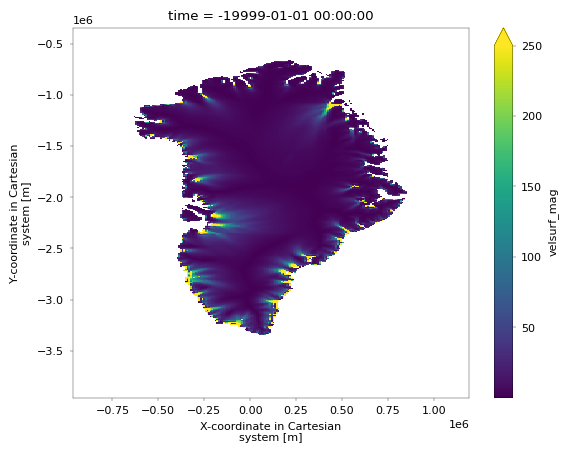

In [594]:
state_ds.isel(time=-1).median(dim="id")["velsurf_mag"].plot(vmax=250)

/home/andy/miniconda3/envs/pism-ragis/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


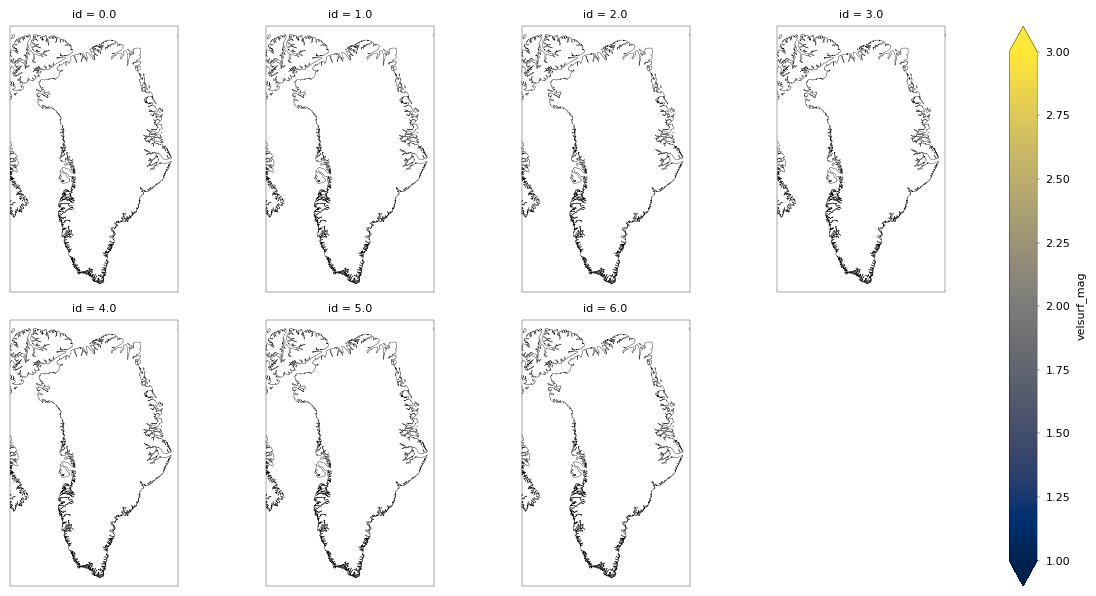

In [647]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
f = np.log10(spatial_ds.sel(time=cftime.DatetimeNoLeap(-124000, 1, 1), method="nearest")["velsurf_mag"]).plot(vmin=1, vmax=3, cmap="cividis", 
                                                                                                              col="id", col_wrap=4,                                                            
                                                                                                              transform=ccrs.PlateCarree(),
                                                                                                              subplot_kws={"projection": crs})
for f_ax in f.axs.flat:
    f_ax.coastlines(linewidth=0.25, resolution="10m")
    f_ax.set_extent([-60, -30, 58, 85])

In [637]:
spatial_ds.sel(time=cftime.DatetimeNoLeap(-120000, 1, 1), method="nearest")["velsurf_mag"]

<xarray.DataArray 'velsurf_mag' (id: 7, y: 401, x: 240)>
dask.array<getitem, shape=(7, 401, 240), dtype=float32, chunksize=(1, 401, 240), chunktype=numpy.ndarray>
Coordinates:
    time     object -119875-01-01 00:00:00
  * x        (x) float64 -9.622e+05 -9.532e+05 -9.442e+05 ... 1.18e+06 1.189e+06
  * y        (y) float64 -3.952e+06 -3.943e+06 ... -3.611e+05 -3.521e+05
  * id       (id) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0

In [217]:
ds = xr.open_dataset(snap_files[0])
m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
ds = ds.expand_dims("id").assign_coords({"id": ("time", [0])})

In [625]:
import cftime
import nc_time_axis

In [145]:
state_ds = xr.open_mfdataset(state_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

In [135]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)


ConversionError: Failed to convert value(s) to axis units: <xarray.DataArray 'time' (time: 125001)>
array([cftime.DatetimeNoLeap(-124999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(-124998, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(-124997, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       ..., cftime.DatetimeNoLeap(-1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(0, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time      (time) object -124999-01-01 00:00:00 ... 0001-01-01 00:00:00
    quantile  float64 0.5
Attributes:
    axis:       T
    long_name:  time

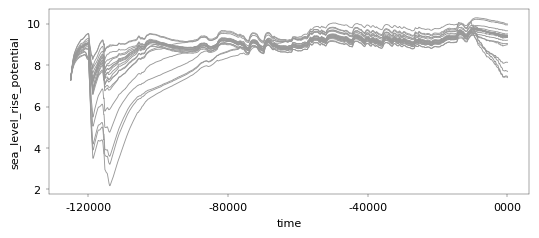

In [626]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
scalar_ds[plot_var].plot.line(x="time", color="0.6", ax=ax, add_legend=False)

q_16 = scalar_ds[plot_var].quantile(0.16, dim="id")
q_50 = scalar_ds[plot_var].quantile(0.50, dim="id")
q_84 = scalar_ds[plot_var].quantile(0.84, dim="id")
ax.fill_between(q_50["time"], q_16, q_84, color="b")
q_50.plot.line(x="time", color="k", lw=2, ax=ax, label="median", add_legend=False)
median_line = mlines.Line2D(
    [], [], color="k", linewidth=2, label="Median"
    )
legend = ax.legend(handles=[median_line], loc="lower left", bbox_to_anchor=(0.3, 0.0))
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
ax.add_artist(legend)

ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(fig_path / f"{plot_var}_paleo-ensemble-{grid_res}m.pdf")

In [621]:
q_50

<xarray.DataArray 'sea_level_rise_potential' (time: 125001)>
dask.array<getitem, shape=(125001,), dtype=float64, chunksize=(125001,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object -124999-01-01 00:00:00 ... 0001-01-01 00:00:00
    quantile  float64 0.5

In [170]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
f = np.log10(snap_ds["velsurf_mag"].median(dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6, 
                                                           transform=ccrs.PlateCarree(),
                                                           subplot_kws={"projection": crs})
for f_ax in f.axs.flat:
    f_ax.coastlines(linewidth=0.25, resolution="10m")
    f_ax.set_extent([-60, -30, 58, 85])
f.fig.savefig(fig_path / "test.png", dpi=600)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f7a80aaa980> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7a0c64c2c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/home/andy/miniconda3/envs/pism-ragis/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


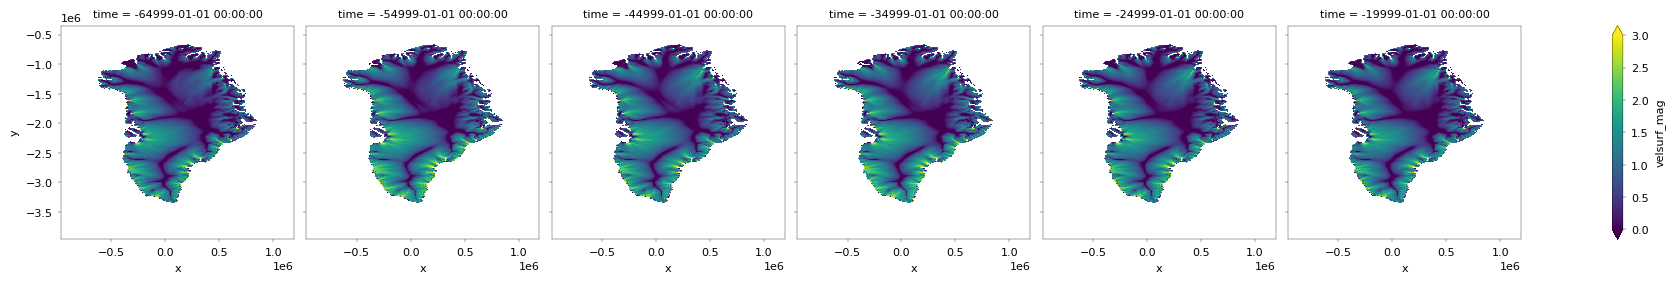

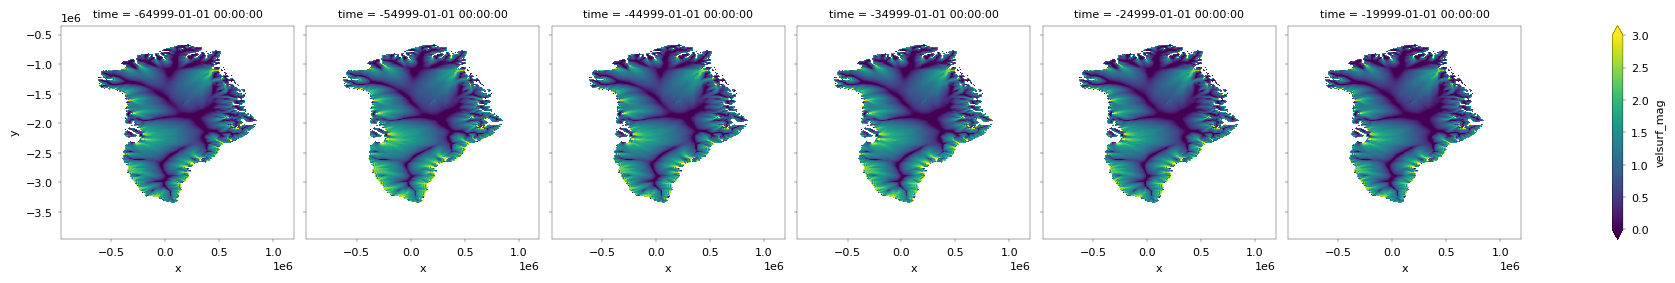

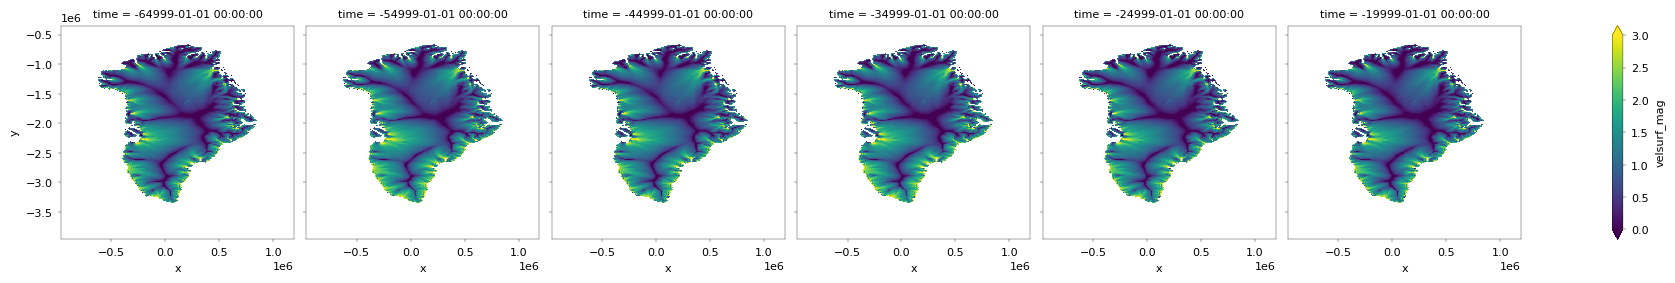

In [434]:
for q in [0.05, 0.5, 0.95]:
    f = np.log10(snap_ds["velsurf_mag"].quantile(q, dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6)
    f.fig.savefig(fig_path / f"ens_pctl_{q}.png", dpi=600)

In [427]:
np.log10(snap_ds["velsurf_mag"].quantile(5, dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6)

ValueError: dimension id on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(id=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [ ]:
median = dask.delayed(ds["isochronal_layer_thicknes"].median(dim="id"))
with ProgressBar():
    results = median.compute()

In [ ]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
results[0,:,:,10].plot(ax=ax)

In [ ]:
median = dask.delayed(ds["velsurf_mag"].median(dim="id"))
with ProgressBar():
    results = median.compute()

In [ ]:
np.log10(results).plot(vmin=0, vmax=3)

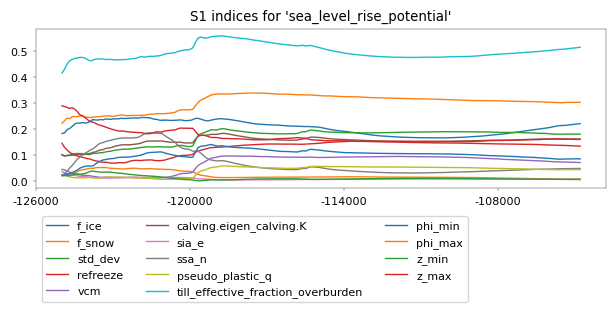

In [46]:
    si = "S1"
    outfile = f"""test.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 5.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [40]:
ds["sea_level_rise_potential"][9, :].values

array([7.28421489, 7.28537764, 7.28637919, ...,        nan,        nan,
              nan])

In [51]:
calib_ds = xr.open_dataset("../calibration/2023_10_init_ragis_tillwat/state/gris_g600m_v2023_RAGIS_id_BAYES-MEDIAN_0_25_mass_transport_failed.nc")

In [402]:
len(snap_files)

120

In [349]:
cftime.DatetimeNoLeap(-2000, 1, 1)

cftime.DatetimeNoLeap(-2000, 1, 1, 0, 0, 0, 0, has_year_zero=True)

In [365]:
rm ens_*.nc

In [387]:
ds = xr.open_dataset(snap_files[0])
m_id_re = re.search("id_(.+?)_", ds.encoding["source"])

assert m_id_re is not None
m_id: Union[str, int]
try:
    m_id = int(m_id_re.group(1))
except:
    m_id = str(m_id_re.group(1))
ds["id"] = m_id
ds = ds.expand_dims("id")
if "nv" in ds.sizes:
    ds = ds.mean(dim="nv")

In [388]:
ds

<xarray.Dataset>
Dimensions:                                      (id: 1, time: 1, x: 240,
                                                  y: 401, z: 401, x_lc: 957,
                                                  y_lc: 1601, zb: 21,
                                                  deposition_time: 26)
Coordinates:
  * time                                         (time) object -19999-01-01 0...
  * x                                            (x) float64 -9.622e+05 ... 1...
  * y                                            (y) float64 -3.952e+06 ... -...
    lat                                          (y, x) float64 ...
    lon                                          (y, x) float64 ...
  * z                                            (z) float64 0.0 3.148 ... 5e+03
  * x_lc                                         (x_lc) float64 -4.189e+06 .....
  * y_lc                                         (y_lc) float64 -9.352e+06 .....
  * zb                                           (zb) float64 -2e+03 ... 0.0
  * deposition_time                              (deposition_time) object -12...
Dimensions without coordinates: id
Data variables: (12/66)
    mapping                                      (id) float64 9.223e+207
    pism_config                                  (id) int8 57
    run_stats                                    (id) float64 3.477e+226
    timestamp                                    (id, time) timedelta64[ns] 2...
    thk                                          (id, time, y, x) float64 0.0...
    ice_area_specific_volume                     (id, time, y, x) float64 0.0...
    ...                                           ...
    vbar                                         (id, time, y, x) float32 0.0...
    uvelbase                                     (id, time, y, x) float32 -2e...
    vvelbase                                     (id, time, y, x) float32 -2e...
    velsurf_mag                                  (id, time, y, x) float32 nan...
    wvelbase                                     (id, time, y, x) float32 nan...
    id                                           (id) int64 0
Attributes:
    Conventions:  CF-1.6
    command:       /home1/aaschwan/local/pism-dev/bin/pismr -profile /nobacku...
    history:      aaschwan@r401i0n12 2024-01-09 16:30:36 PST: PISM (2024-01-0...
    institution:  University of Alaska Fairbanks
    proj:         epsg:3413
    source:       PISM (2024-01-09-d463d4112 committed by Constantine Khrulev...

In [506]:


def preprocess(ds):
    ds["experiment_id"] = ds.attrs["experiment_id"]
    source_id = ds.attrs["source_id"]
    ds = ds.assign_coords({"source_id": source_id}).drop_vars("height", errors="ignore")
    ds = ds.sel(lat=slice(60, 85), lon=slice(285, 350))
    return ds


for (m_var, m_exp), m_df in intersection_df.groupby(by=["variable_id", "experiment_id"]):
    p = m_df["filename"]
    ds = xr.open_mfdataset(p, parallel=True, concat_dim="source_id", combine="nested",
                           data_vars='minimal', coords='minimal', compat='override', preprocess=preprocess, decode_times=False)
    f = ds.sel(source_id=gcm_sel)[m_var].mean(dim="time").plot(figsize=(6.2, 2.4),
                                        col="source_id", 
                                        col_wrap=len(gcm_sel), 
                                        transform=ccrs.PlateCarree(), 
                                        cbar_kwargs={"location": "right", "orientation": "vertical", 
                                                     "fraction": 0.085, "shrink": 0.6, "label": ds[m_var].units},
                                        subplot_kws={"projection": crs})
    mean = ds.sel(source_id=gcm_sel)[m_var].mean(dim=["time", "lat", "lon"]).to_dataframe()
    variance = ds[m_var].std(dim=["time", "source_id"])
    [f.axs.ravel()[source[0]].text(0.5, 0.1, f"""mean={np.round(source[1][-1].to_numpy()[0])}""", color="w", horizontalalignment='center',
     verticalalignment='center', transform=f.axs.ravel()[source[0]].transAxes) for source in enumerate(mean.iterrows())]
    for f_ax in f.axs.flat:
        f_ax.coastlines(linewidth=0.25, resolution="10m")
        f_ax.set_extent([-60, -30, 58, 85])


    f.fig.subplots_adjust(wspace=.1, hspace=.1, right=0.9)
    f.fig.savefig(f"{m_var}_{m_exp}.png", dpi=600)
    fig, ax = plt.subplots(1, 1)
    f_var = variance.plot(ax=ax)

NameError: name 'intersection_df' is not defined

Text(0.5, 1.0, 'time = -124875-01-01T00:00:00')

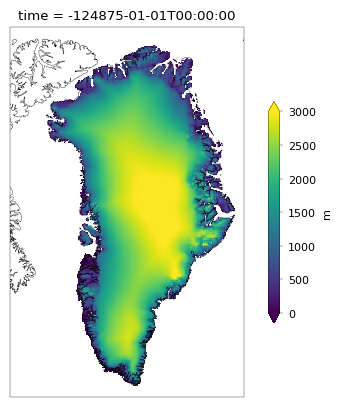

In [578]:
from matplotlib import animation
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)

m_ds = spatial_ds.median(dim="id")
t_ds = m_ds.isel(time=0)
im = t_ds["usurf"].where(t_ds["thk"]>0).plot(vmin=0, vmax=3000,
                             transform=crs, 
                             cbar_kwargs={"location": "right", "orientation": "vertical", 
                                          "fraction": 0.085, "shrink": 0.6, "label": "m"},
                             subplot_kws={"projection": crs})

im.axes.coastlines(linewidth=0.25, resolution="10m")
im.axes.set_extent([-60, -30, 58, 85])
im.axes.set_title(f"""time = {spatial_ds["time"].values[0].isoformat()}""")

In [579]:
def animate(i):
    t_ds = m_ds.isel(time=i)
    array = t_ds["usurf"].where(t_ds["thk"]>0).values
    im.set_array(array.flatten())
    im.axes.set_title(f"""time = {spatial_ds["time"].values[i].isoformat()}""")
    

In [580]:
del ani
# ani = animation.FuncAnimation(fig, animate, len(spatial_ds["time"]), interval=150)
ani = animation.FuncAnimation(im.figure, animate, 500, interval=150)

In [581]:
ani.save("median.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [556]:
from IPython.display import HTML
HTML(ani.to_jshtml())

KeyboardInterrupt: 

In [487]:
t = spatial_ds["time"].values[0]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(-124875, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object -124875-01-01 00:00:00
Attributes:
    axis:       T
    long_name:  time
    bounds:     time_bounds

In [511]:
im.axes.sett

<xarray.DataArray 'usurf' (time: 500, y: 401, x: 240)>
dask.array<nanmedian, shape=(500, 401, 240), dtype=float32, chunksize=(19, 401, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object -124875-01-01 00:00:00 ... -0125-01-01 00:00:00
  * x        (x) float64 -9.622e+05 -9.532e+05 -9.442e+05 ... 1.18e+06 1.189e+06
  * y        (y) float64 -3.952e+06 -3.943e+06 ... -3.611e+05 -3.521e+05

In [542]:
usurf

<xarray.DataArray 'usurf' (time: 100, y: 401, x: 240)>
dask.array<nanmedian, shape=(100, 401, 240), dtype=float32, chunksize=(19, 401, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object -124875-01-01 00:00:00 ... -1125-01-01 00:00:00
  * x        (x) float64 -9.622e+05 -9.532e+05 -9.442e+05 ... 1.18e+06 1.189e+06
  * y        (y) float64 -3.952e+06 -3.943e+06 ... -3.611e+05 -3.521e+05

In [582]:
ds_0 = xr.open_dataset("/data/work/gris-paleo/data/2023_11_climate_calving_w_posterior/scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_0_-125001_0.nc")
ds_1 = xr.open_dataset("/data/work/gris-paleo/data/2024_01_climate_float_kill/scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_0_-125001_0.nc")

/home/andy/miniconda3/envs/pism-ragis/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


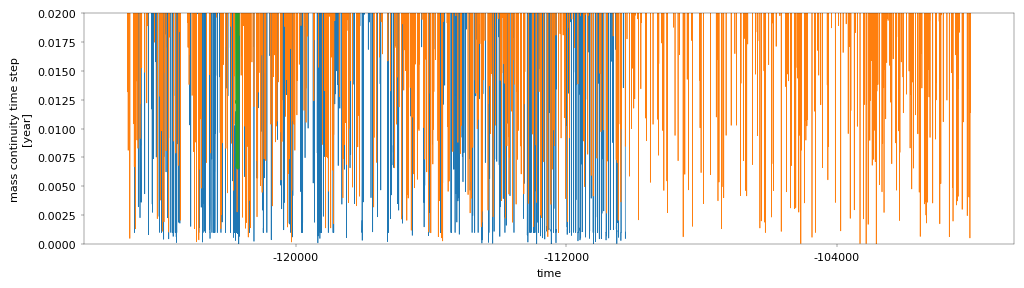

In [609]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_ylim(0, 0.02)
ds_0.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].plot(ax=ax, lw=0.5)
ds_1.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].plot(ax=ax, lw=0.5)
ds_0.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].rolling(time=100).mean().plot(ax=ax, lw=2)
ds_1.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].rolling(time=100).mean().plot(ax=ax, lw=2)

In [611]:
1e19-1.e16

9.99e+18

In [648]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)

In [649]:
10,198,227,249,255,10
100,87,200,255,255,100
250,0,42,255,255,250
750,197,27,158,255,750
1500,169,19,24,255,1500


(1500, 169, 19, 24, 255, 1500)

In [662]:
x = np.arange(5)
y = np.array([10., 100., 250., 750., 1500.])
y /= np.max(y)

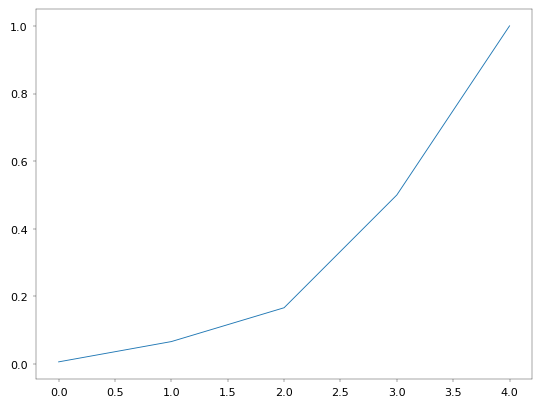

In [666]:
c = np.polyfit(x, y, 3)

ValueError: minvalue must be less than or equal to maxvalue

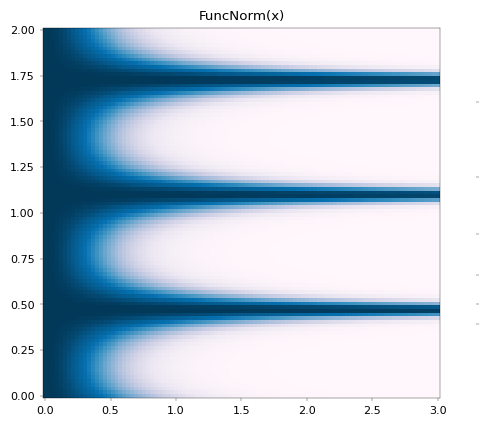

In [673]:
from matplotlib import colors

def _forward(x):
    return 1 / (c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3)


def _inverse(x):
    return c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3

N = 100
X, Y = np.mgrid[0:3:complex(0, N), 0:2:complex(0, N)]
Z1 = (1 + np.sin(Y * 10.)) * X**2
fig, ax = plt.subplots()

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1500)
pcm = ax.pcolormesh(X, Y, Z1, norm=norm, cmap='PuBu_r', shading='auto')
ax.set_title('FuncNorm(x)')
fig.colorbar(pcm, shrink=0.6)
plt.show()


In [669]:
c

array([0.01055556, 0.01619048, 0.01468254, 0.01038095])

In [24]:
718.12+875.07

1593.19